In [ ]:
#!pip install -r requirements.txt

In [1]:
# import necessary functions and libraries

import torch
import time
import matplotlib.pyplot as plt
from data.load_trajectory import generate_bloch_trajectory
from data.noisy_data import generate_data
from train.pinn_simulation import BlochNN, train_pinn
from train.param_estimator import train_inv_pinn_1, train_inv_pinn_2
from figures.bloch_animation import create_interactive_bloch_sphere
import warnings
warnings.filterwarnings("ignore")

## Numerical solution of the Bloch vector equations

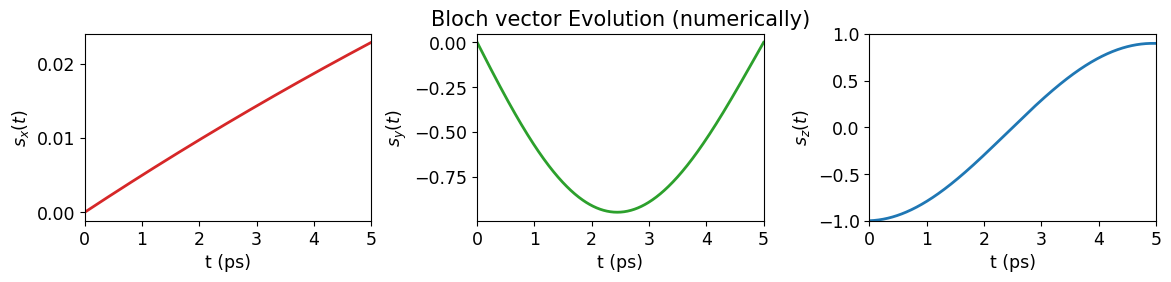

Time elapsed : 0.45976734161376953 s


In [4]:
start = time.time()
t, sx, sy, sz = generate_bloch_trajectory(
    alpha = torch.tensor(0.126),
    v_c = torch.tensor(3.04),
    T = 10.0,
    D = 5.0,
    S0=[0.0, 0.0, -1.0],
    t_intervals=500,
    plot = True
)
end = time.time()

print(f"Time elapsed : {end-start} s")

## Bloch sphere visualization

In [3]:
fig = create_interactive_bloch_sphere(sx=sx.flatten(), sy=sy.flatten(), sz=sz.flatten(), t_eval=t.flatten())
fig.show()

## Training the neural network to learn the solutions to the Bloch vectorized Lindblad master equations

Epoch : 0  |  Loss = 0.7854482531547546  |  RMSE = [0.18977834589466486, 0.7690667673101941, 0.6746910025579036]


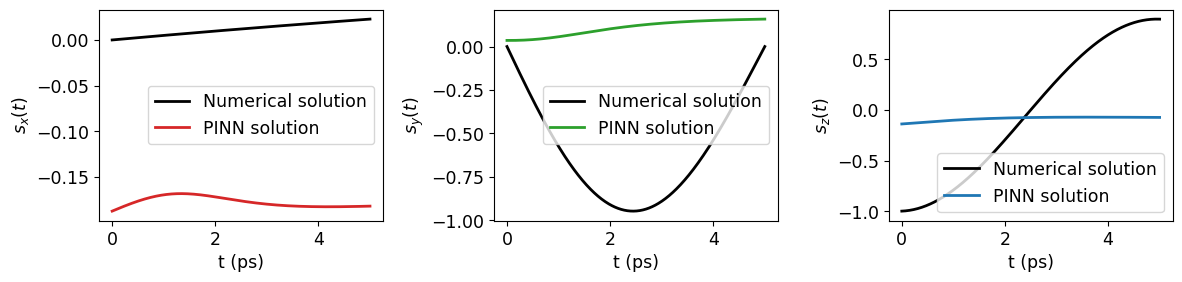

Epoch : 1000  |  Loss = 0.0007976426859386265  |  RMSE = [0.027979024800393385, 0.5333396472542044, 0.8084948667094572]


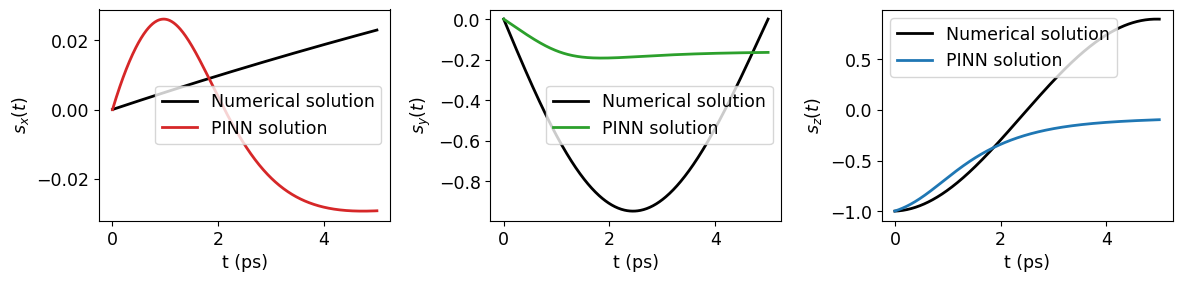

Epoch : 2000  |  Loss = 0.00046570473932661116  |  RMSE = [0.025943258164291955, 0.4044548279926815, 0.7883420003342944]


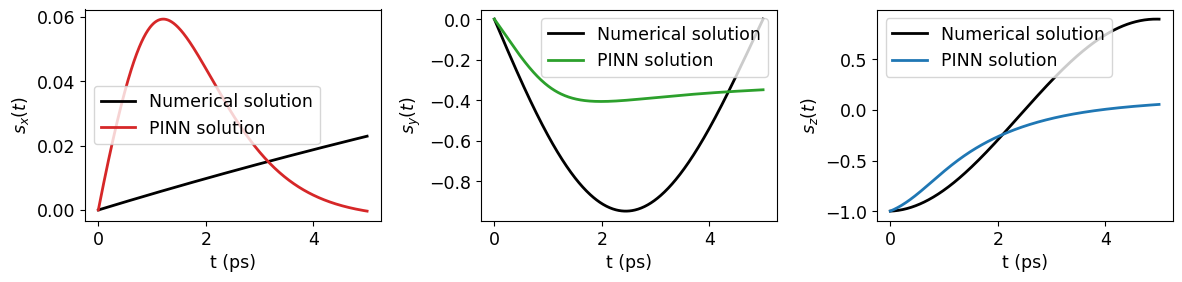

Epoch : 3000  |  Loss = 0.0003606437239795923  |  RMSE = [0.026094154748354664, 0.386643540165315, 0.7916415360172049]


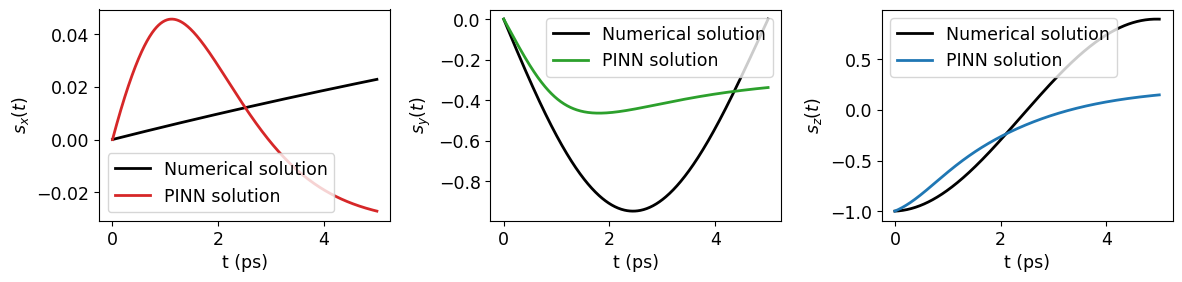

Epoch : 4000  |  Loss = 0.00028369674691930413  |  RMSE = [0.03054336853718522, 0.3739521202597664, 0.8009671072194766]


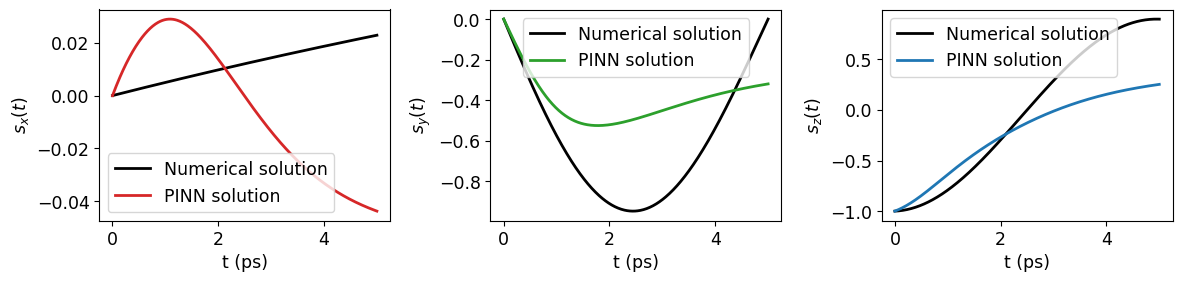

Epoch : 5000  |  Loss = 0.00022120897483546287  |  RMSE = [0.028266425082415593, 0.3648840136976582, 0.814442010775117]


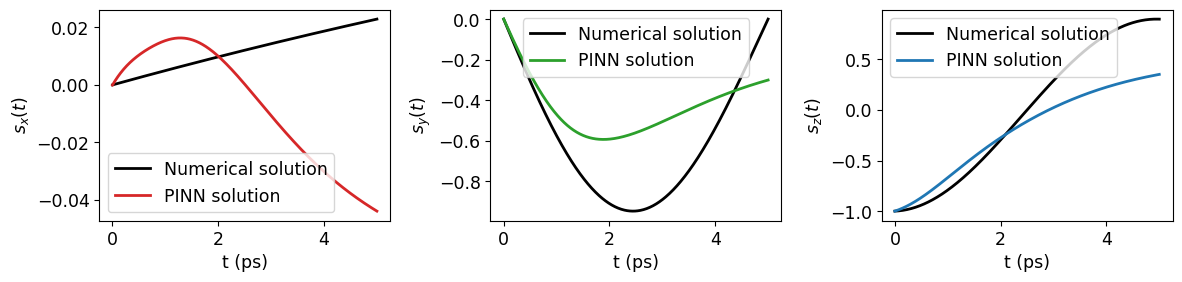

Epoch : 6000  |  Loss = 0.00015709956642240286  |  RMSE = [0.02228691834921328, 0.36584211534131256, 0.8304750410799941]


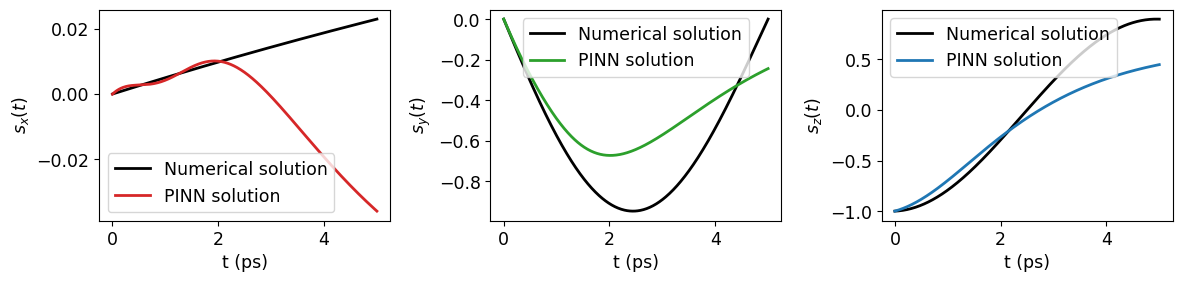

Epoch : 7000  |  Loss = 9.928473446052521e-05  |  RMSE = [0.013200041467221656, 0.37291557417813886, 0.8529276970714386]


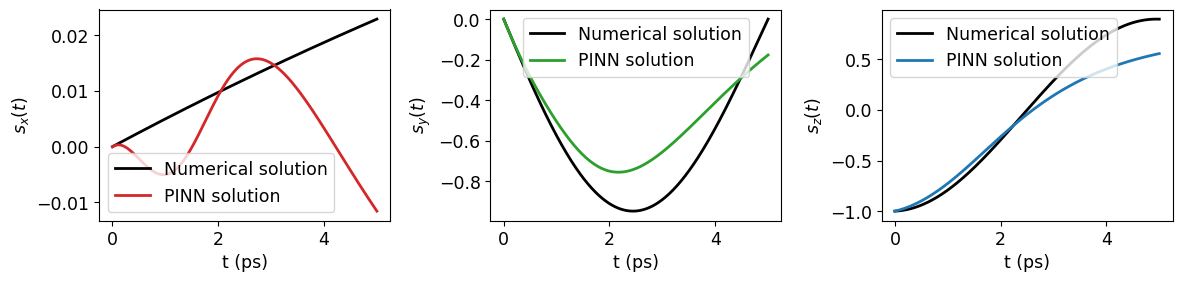

Epoch : 8000  |  Loss = 5.7808738347375765e-05  |  RMSE = [0.013019749282583969, 0.3801313536981179, 0.8787005574236114]


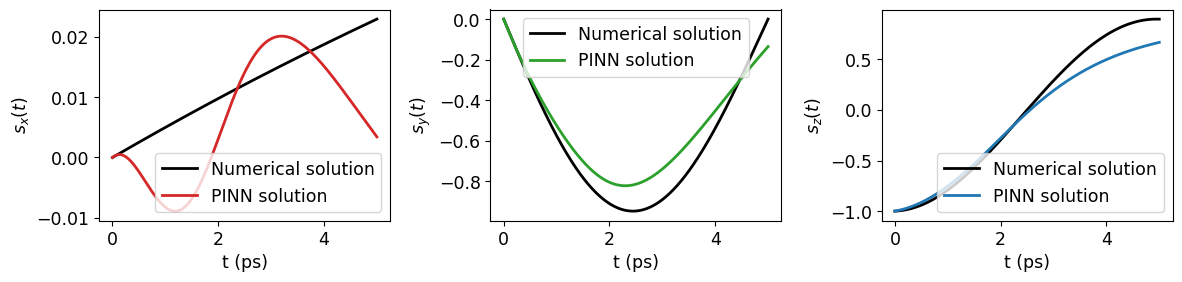

Epoch : 9000  |  Loss = 3.333920176373795e-05  |  RMSE = [0.012352535408527977, 0.38847061650819287, 0.9009850619840437]


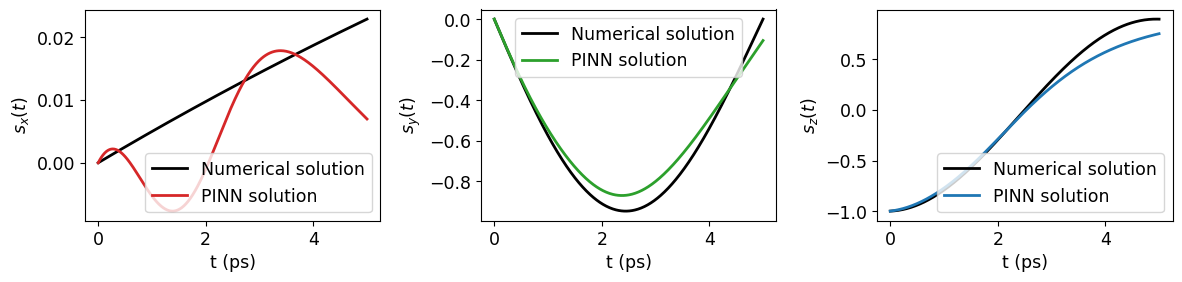

Epoch : 10000  |  Loss = 2.1275576727930456e-05  |  RMSE = [0.011234895343239733, 0.39511834699514836, 0.9156707486520939]


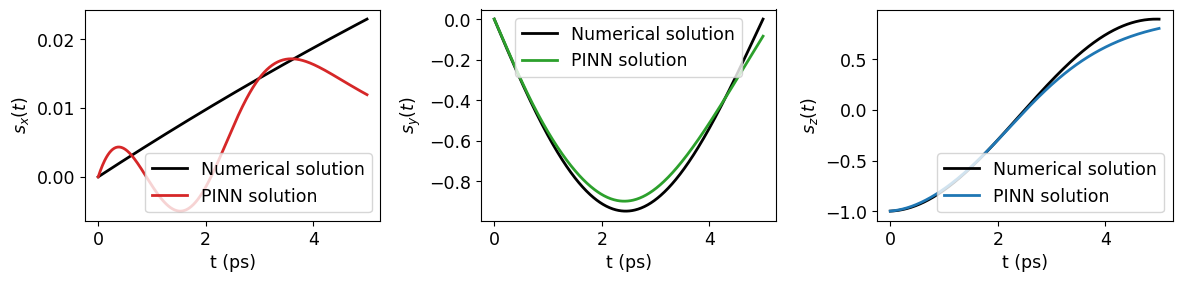

Epoch : 11000  |  Loss = 1.515522126283031e-05  |  RMSE = [0.010456263515563004, 0.3995732684944693, 0.9244827255157776]


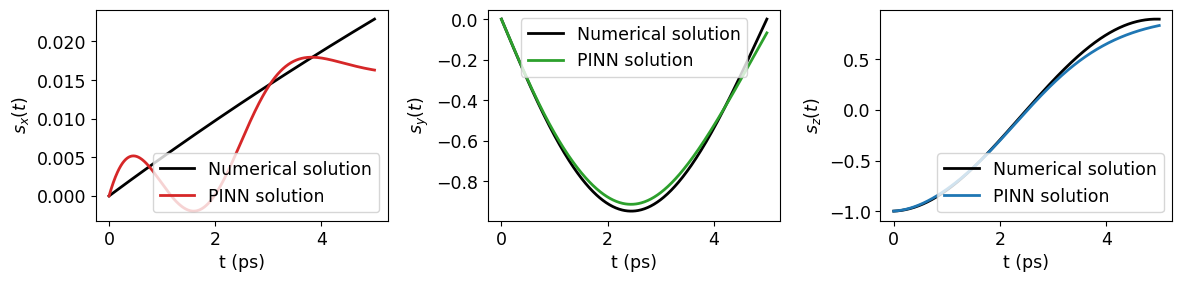

Epoch : 12000  |  Loss = 9.966232028091326e-06  |  RMSE = [0.009947891095761944, 0.4028482759231446, 0.9305021895989986]


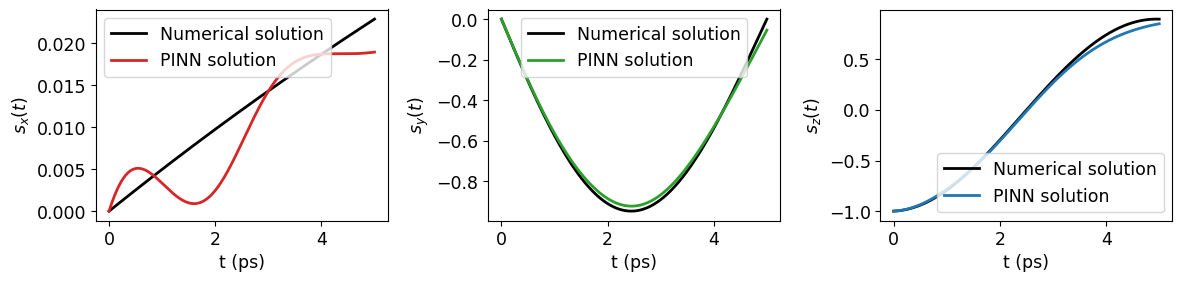

Epoch : 13000  |  Loss = 6.981656952120829e-06  |  RMSE = [0.009628888958224335, 0.4053905327954591, 0.9349887434172311]


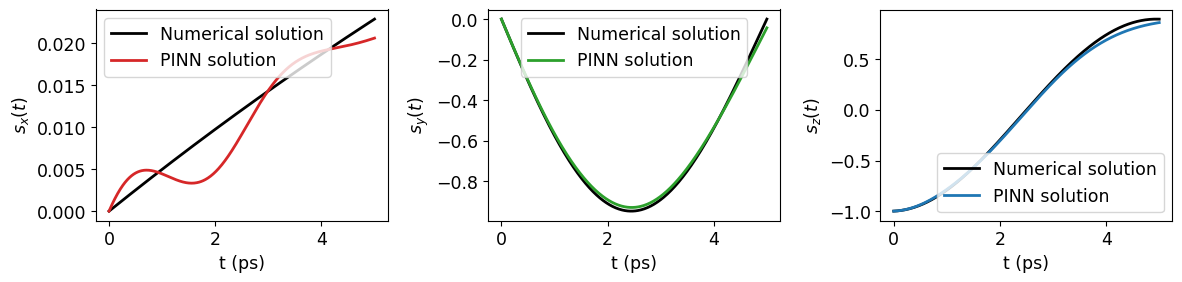

Epoch : 14000  |  Loss = 4.952211384079419e-06  |  RMSE = [0.009493114420142595, 0.4073833112788153, 0.9384414469095742]


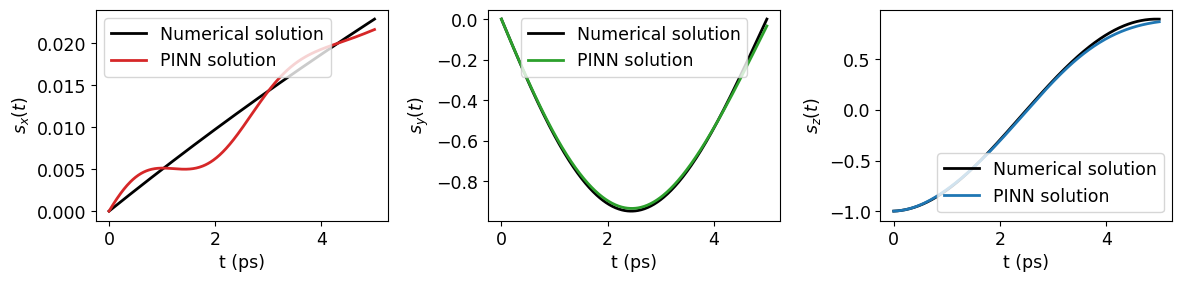

Epoch : 15000  |  Loss = 3.579095164241153e-06  |  RMSE = [0.009442650674290292, 0.4088751381348731, 0.9410122521324014]


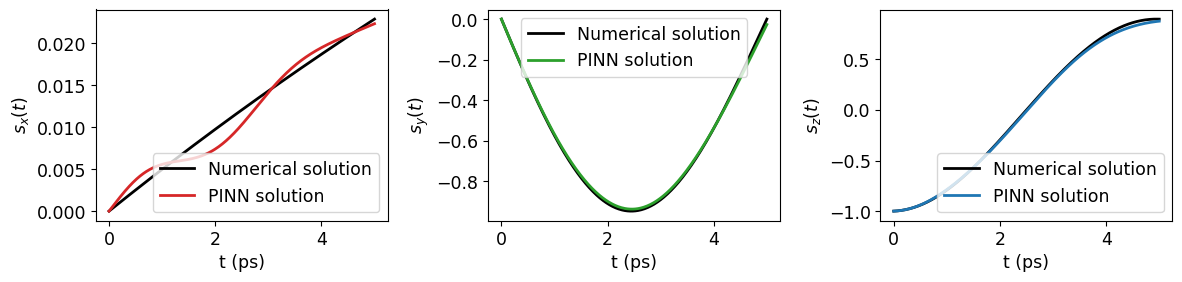

Time elapsed: 70.47229480743408 s


In [5]:
torch.manual_seed(2025)

# Specify the physical constants
alpha = torch.tensor(0.126)                  # ps/K
v_c = torch.tensor(3.04)                  # 1/ps
T = torch.tensor(10.0)                    # K
D = torch.tensor(5.0)                     # ps
t_intervals = 500
N = 25

# Create PINN
pinn = BlochNN(n_input=1, n_output=3, n_hidden=32, n_layers=4)

# Prepare training/test inputs
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, D, N).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, D, t_intervals).view(-1, 1)

# Train
start = time.time()

model1 = train_pinn(pinn, t_physics, t_boundary, t_test,
           alpha, v_c, T, D, sx, sy, sz, S0=[0.0, 0.0, -1.0],
           lambda1=1e-2, epochs=15001, lr=1e-4, weight_decay=0,
           plot_interval=1000, plot_loss=False)

end = time.time()

print(f"Time elapsed: {end- start} s")

## Inferencing the trained PINN on unseen time instances

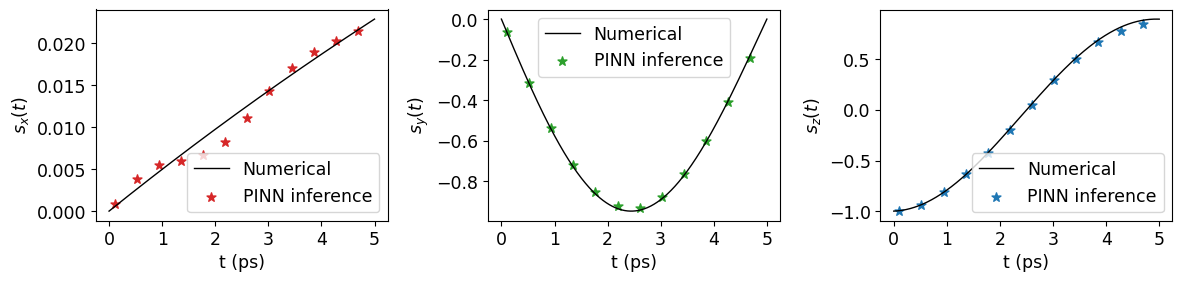

In [6]:
t_test = []
for i in range(0,len(t_physics)-2,2):
    t_test.append((t_physics[i]+t_physics[i+1])/2)

t_test = torch.tensor(t_test).view(-1,1)

with torch.no_grad():
    results = model1(t_test)

plt.rcParams['font.size'] = 12.5

fig, axes = plt.subplots(1,3, figsize=(12,3))

axes[0].plot(t, sx, label="Numerical", color="black", linewidth=1)
axes[0].scatter(t_test, results[:, 0], label="PINN inference", color="tab:red", marker='*', s=45)
axes[0].set_xlabel("t (ps)")
axes[0].set_ylabel(r"$s_x (t)$")
axes[0].set_xticks([0, 1, 2, 3 ,4, 5])
axes[0].legend()

axes[1].plot(t, sy, label="Numerical", color="black", linewidth=1)
axes[1].scatter(t_test, results[:, 1], label="PINN inference", color="tab:green", marker='*', s=45)
axes[1].set_xlabel("t (ps)")
axes[1].set_ylabel(r"$s_y (t)$")
axes[1].set_xticks([0, 1, 2, 3 ,4, 5])
#axes[1].set_title(f"Epoch: {i},  loss = {round(loss.item(), 6)}")
axes[1].legend()

axes[2].plot(t, sz, label="Numerical", color="black", linewidth=1)
axes[2].scatter(t_test, results[:, 2], label="PINN inference", color="tab:blue", marker='*', s=45)
axes[2].set_xlabel("t (ps)")
axes[2].set_ylabel(r"$s_z (t)$")
axes[2].set_xticks([0, 1, 2, 3 ,4, 5])
axes[2].legend()

plt.tight_layout()

## Generate synthetic noisy data (representing costly, error-prone measurements)

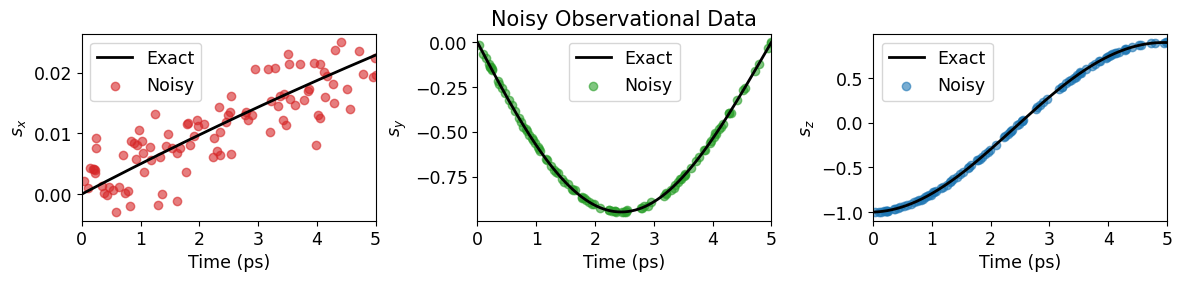

In [7]:
alpha = torch.tensor(0.126)                  # ps/K
v_c = torch.tensor(3.04)                  # 1/ps
T = torch.tensor(10.0)                    # K
D = torch.tensor(5.0)                     # ps


t_obs, sx_obs, sy_obs, sz_obs = generate_data(sx, sy, sz, D, noise_std=0.004, M=100, plot=True)

## Inverse problem 1: Estimation of coupling strength '$\alpha$' from noisy data

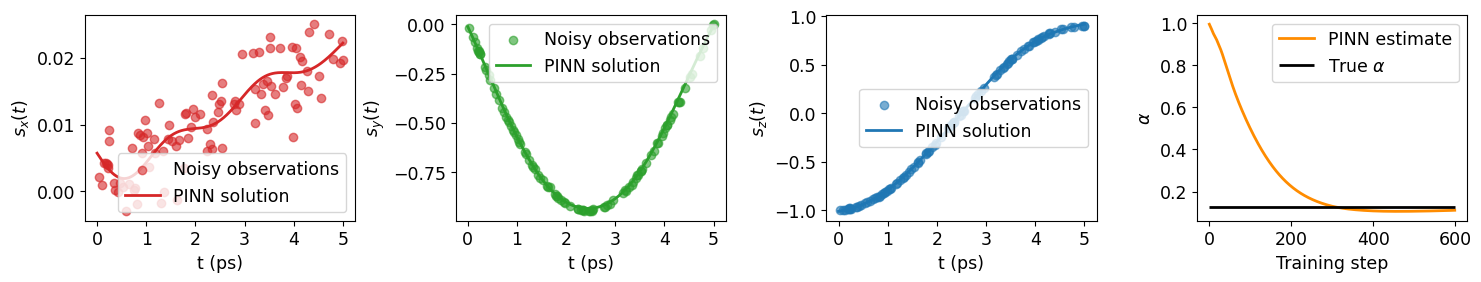

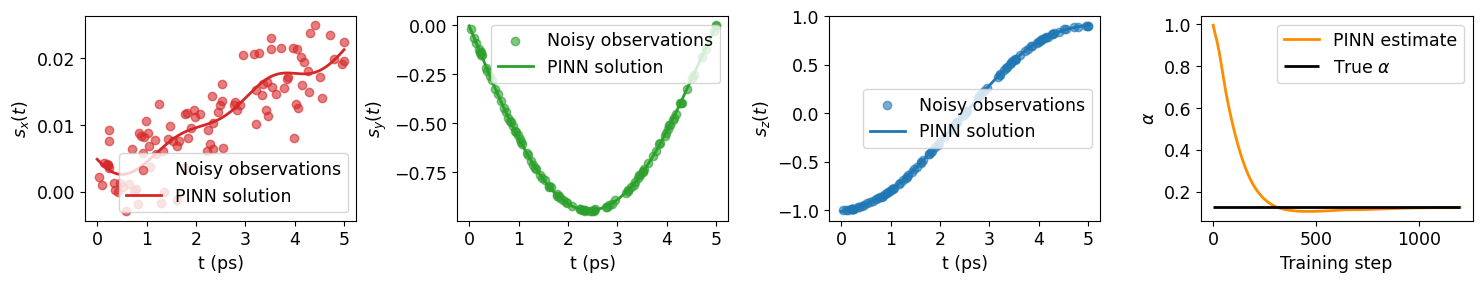

Time elapsed: 10.145694732666016 s
Actual value of coupling strength = 0.12600000202655792 
Predicted value of coupling strength = 0.12515896558761597
Error = 0.667489230632782 %


In [22]:
t_test = torch.linspace(0,D,500).view(-1,1)

start = time.time()
alpha_pred, model2 = train_inv_pinn_1(alpha, v_c, T, D, t_obs, sx_obs, sy_obs, sz_obs, 
                                t_test, t_intervals=500, hidden_dim=32, n_layers=4, 
                                epochs=1201, lr=5e-3, lam1=1e-3, lam2=1, plot_interval=600)
end = time.time()

print(f"Time elapsed: {end-start} s")

print(f"Actual value of coupling strength = {alpha} ")
print(f"Predicted value of coupling strength = {alpha_pred}")
print(f"Error = {abs(alpha - alpha_pred)*100/alpha} %")

## Inverse problem 2 : Estimation of cutoff frequency 'v_c' from noisy data

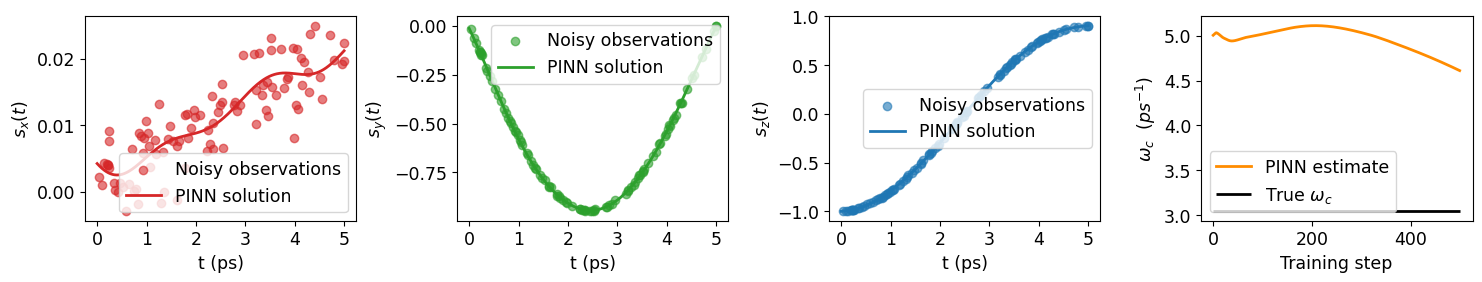

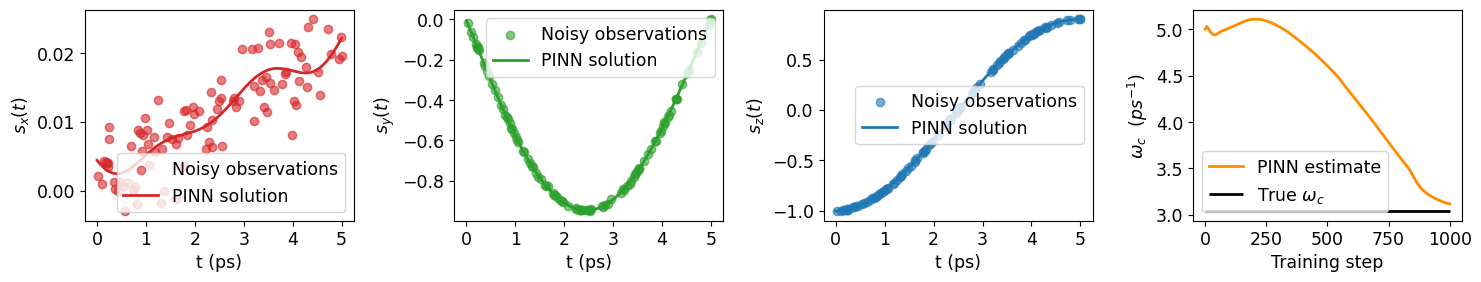

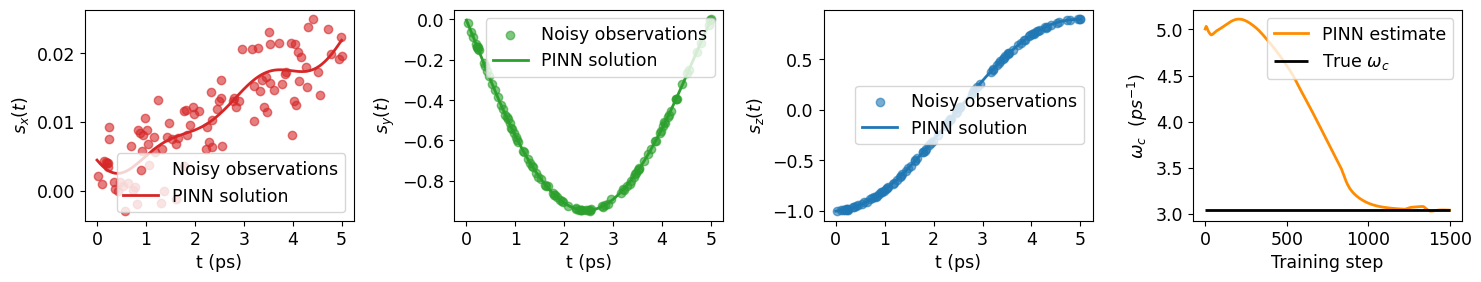

Time elapsed: 13.103661060333252 s
Actual value of cutoff frequency = 3.0399999618530273 1/ps
Predicted value of cutoff frequency = 3.0393190383911133 1/ps
Error = 0.022398797795176506 %


In [18]:
alpha = torch.tensor(0.126)
t_test = torch.linspace(0,D,500).view(-1,1)

start = time.time()
vc_pred, model3 = train_inv_pinn_2(v_c, alpha, T, D, t_obs, sx_obs, sy_obs, sz_obs, 
                                t_test, t_intervals=500, hidden_dim=32, n_layers=4, 
                                epochs=1501, lambda1=1e2, lr=5e-3, plot_intervals=500)
end = time.time()
print(f"Time elapsed: {end-start} s")
print(f"Actual value of cutoff frequency = {v_c} 1/ps")
print(f"Predicted value of cutoff frequency = {vc_pred} 1/ps")
print(f"Error = {abs(v_c - vc_pred)*100/v_c} %")

## Sensitivity analysis

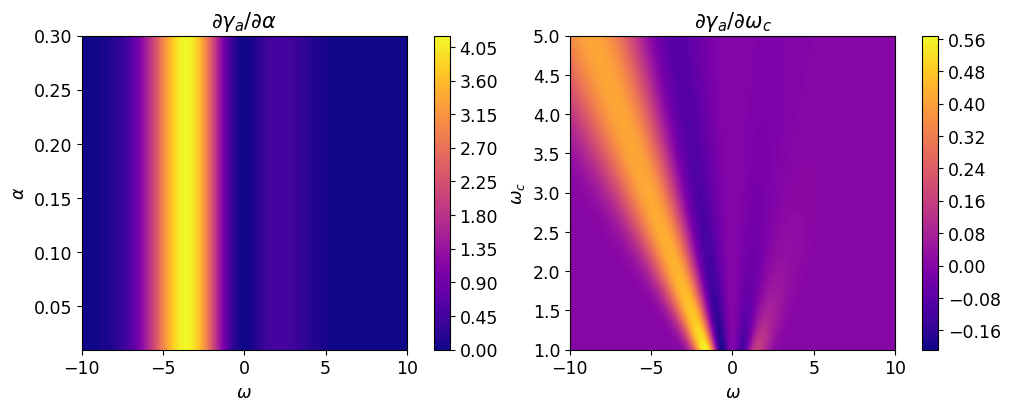

In [1]:
%run sensitivity.py